In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import confusion_matrix, plot_confusion_matrix

import sklearn.metrics as metrics

In [24]:
#This function can be used to quickly plot a nice-looking confusion matrix
    
def plot_cm(est, X, y, norm = None):
    sns.set_context('talk') #Very quick and easy way to change the text sizes
    sns.set_style('white')
    fig, ax = plt.subplots(figsize = (10,8))

    plot_confusion_matrix(est, X, y, cmap = 'BuGn', display_labels=['biology', 'chemistry', 'physics'],
                          ax = ax, normalize = norm, labels = [0,1,2])

    plt.title('Predicted vs True Categories', fontsize = 26);

# With Help From:
# https://medium.com/@panjeh/figure-size-plot-confusion-matrix-in-scikit-learn-2c66f3a69d81
# ...and seaborn documentation

In [3]:
#Read in data, preparing it by dropping Unnamed column and filling null values
biology_data = pd.read_csv('./data/biology_data.csv', index_col='id').drop(columns = 'Unnamed: 0').fillna('')
chemistry_data = pd.read_csv('./data/chemistry_data.csv', index_col='id').drop(columns = 'Unnamed: 0').fillna('')
physics_data = pd.read_csv('./data/physics_data.csv', index_col='id').drop(columns = 'Unnamed: 0').fillna('')

In [4]:
#Create a complete database with all three subreddit data
full_data = biology_data.append(chemistry_data).append(physics_data)
full_data['y'] = full_data['subreddit'].map({'biology' : 0, 'chemistry' : 1, 'physics' : 2})
full_data['y'].value_counts(normalize = True)

0    0.361275
1    0.330172
2    0.308553
Name: y, dtype: float64

In [5]:
#Split into X, y, and train/test split dataframes

X = full_data.drop(columns=['y', 'subreddit'])
y = full_data['y']

fullX_train, fullX_test, y_train, y_test = train_test_split(X, y, random_state = 1701, stratify = y)

#From the full X train and test data, get only the text columns and combine them:
text_X_train = fullX_train['title'] + fullX_train['selftext']
text_X_test = fullX_test['title'] + fullX_test['selftext']

In [6]:
#This creates three training and testing datasets with TfidVectorizer, for quick testing without needing to fit and transform data repeatedly in a grid search

tvec = TfidfVectorizer(max_features=7000)
X_train_tv = pd.DataFrame(tvec.fit_transform(text_X_train).toarray(), columns = tvec.get_feature_names())
X_test_tv = pd.DataFrame(tvec.transform(text_X_test).toarray(), columns = tvec.get_feature_names())

tv2gram = TfidfVectorizer(ngram_range=(1,2), max_features=12000)

X_train_tv2g = tv2gram.fit_transform(text_X_train)
X_test_tv2g = tv2gram.transform(text_X_test)

tv3gram = TfidfVectorizer(ngram_range=(1,3), max_features=14000)

X_train_tv3g = tv3gram.fit_transform(text_X_train)
X_test_tv3g = tv3gram.transform(text_X_test)

In [7]:
lr = LogisticRegression(solver = 'liblinear', C = 3)
lr.fit(X_train_tv, y_train)
print(f'LR w TV:\nTrain : {lr.score(X_train_tv, y_train)}\nTest  : {lr.score(X_test_tv, y_test)}')

LR w TV:
Train : 0.9346158456190818
Test  : 0.8612259572173288


In [8]:
#accuracy with bigrams included
lr.fit(X_train_tv2g, y_train)
lr.score(X_test_tv2g, y_test)

0.8473845047636167

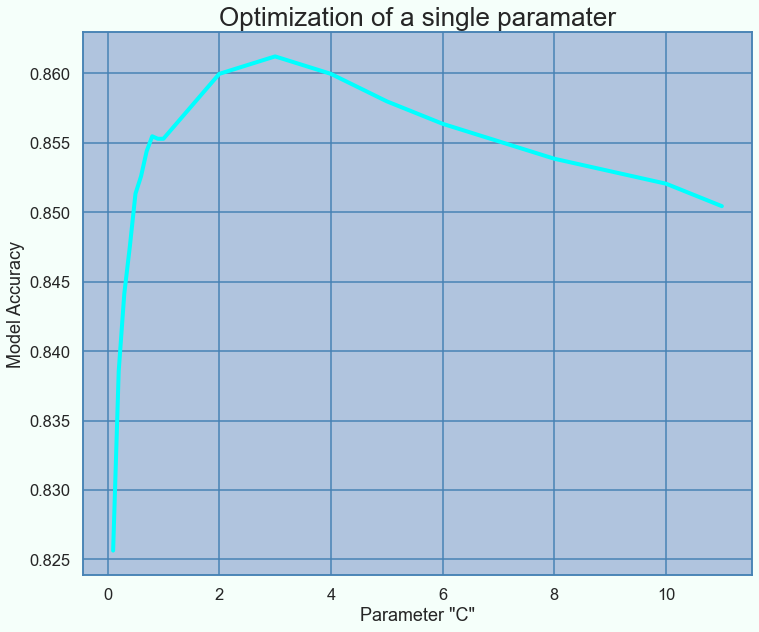

In [9]:
#Create a visualization for demonstrative purposes - what optimization "looks like"

C_list = [x for x in range(1,11)]
scores_list = [[],[]]

lr_temp = LogisticRegression(solver = 'liblinear')

for C in C_list:
    lr_temp.set_params(C = C/10)
    lr_temp.fit(X_train_tv, y_train)
    scores_list[0].append(C/10)
    scores_list[1].append(lr_temp.score(X_test_tv, y_test))
    
for C in C_list:
    lr_temp.set_params(C = C + 1)
    lr_temp.fit(X_train_tv, y_train)
    scores_list[0].append(C+1)
    scores_list[1].append(lr_temp.score(X_test_tv, y_test))

txtcolor = 'white'

sns.set_context('talk')
sns.set_style('darkgrid')
sns.set_style({
    'figure.facecolor' : 'mintcream',
    'axes.facecolor' : 'lightsteelblue',
    'axes.edgecolor' : 'steelblue',
    'grid.color' : 'steelblue',
})


plt.figure(figsize = (12,10))

sns.lineplot(scores_list[0], scores_list[1], color = 'cyan', linewidth = 4)
plt.title('Optimization of a single paramater', fontsize = 26)
plt.ylabel('Model Accuracy')
plt.xlabel('Parameter "C"');

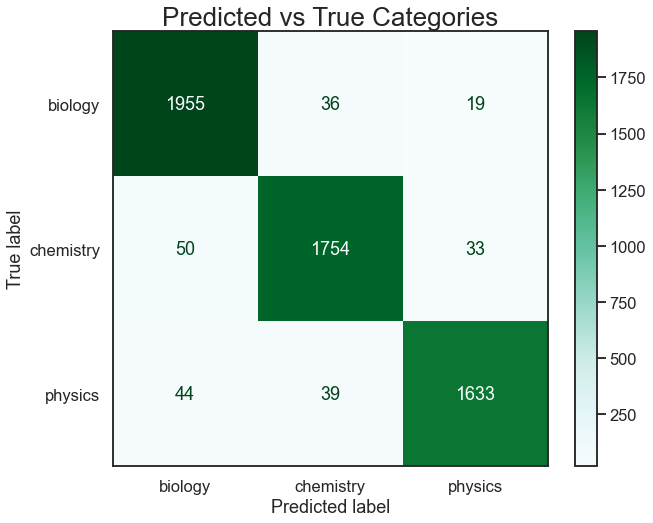

In [25]:
lr = LogisticRegression(solver = 'liblinear', C = 3)
lr.fit(X_test_tv, y_test)
plot_cm(lr, X_test_tv, y_test)

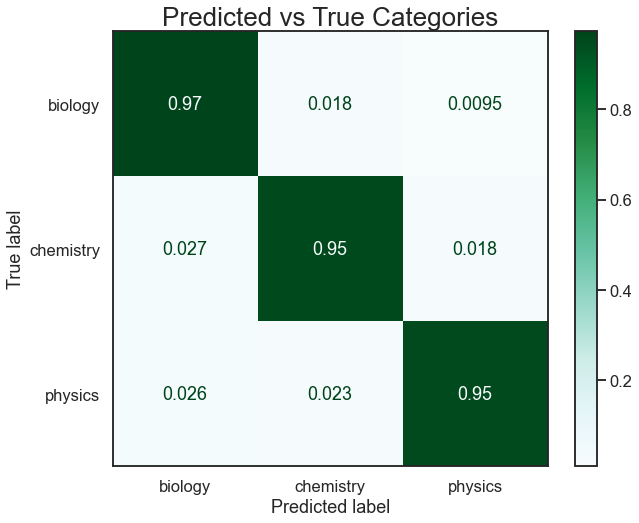

In [26]:
plot_cm(lr, X_test_tv, y_test, norm = 'true')

# Bagging Classifier

In [70]:
bc = BaggingClassifier(base_estimator=lr)
bc.fit(X_train_tv, y_train)

BaggingClassifier(base_estimator=LogisticRegression(C=3, solver='liblinear'))

In [71]:
bc.score(X_train_tv, y_train)

0.9274841184226298

In [72]:
bc.score(X_test_tv, y_test)

0.858709329498472

# LogisticRegression Gridsearch

In [28]:
#grid-searched best parameters for logistic regression

gs = Pipeline(steps=[('tv', TfidfVectorizer(max_features=10000)),
                ('lr',
                 LogisticRegression(C=3, max_iter=300, solver='liblinear'))])

In [29]:
gs.fit(text_X_train, y_train)

Pipeline(steps=[('tv', TfidfVectorizer(max_features=10000)),
                ('lr',
                 LogisticRegression(C=3, max_iter=300, solver='liblinear'))])

In [33]:
gs.score(text_X_train, y_train)

0.9428862519477407

In [32]:
gs.score(text_X_test, y_test)

0.8628437893223081

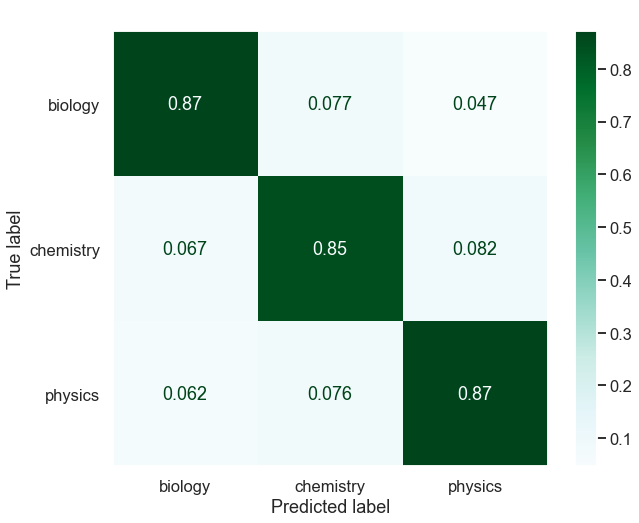

In [328]:
plot_cm(gs, text_X_test, y_test, norm = 'pred')

# Decision Tree

The decision tree runs much faster, and more shallow, with 2- or 3-gram vectors

In [63]:
dt = DecisionTreeClassifier(min_samples_split = 10,ccp_alpha=0.0003)

In [64]:
dt.fit(X_train_tv3g, y_train)

DecisionTreeClassifier(ccp_alpha=0.0003, min_samples_split=10)

In [65]:
dt.score(X_train_tv3g, y_train)

0.7808342322905429

In [66]:
dt.score(X_test_tv3g, y_test)

0.736832644256696

In [67]:
dt.get_depth()

131

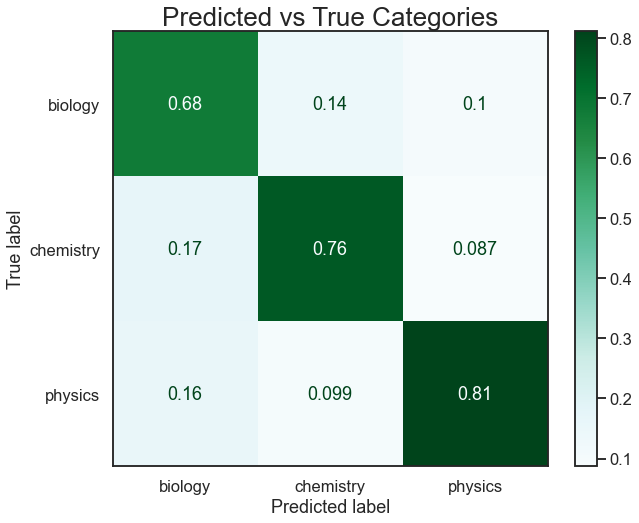

In [68]:
plot_cm(dt, X_test_tv3g, y_test, norm = 'pred')

# SVC

In [42]:
#Gridsearched best estimator:

gs_svc = Pipeline(steps=[('tv', TfidfVectorizer(max_df=5000)),
                ('svc', LinearSVC(C=0.2, max_iter=5000))])

In [43]:
#gs_svc = GridSearchCV(pipe_svc, param_grid=params_svc, cv = 5, n_jobs = 5)
gs_svc.fit(text_X_train, y_train)

Pipeline(steps=[('tv', TfidfVectorizer(max_df=5000)),
                ('svc', LinearSVC(C=0.2, max_iter=5000))])

In [44]:
gs_svc.score(text_X_test, y_test)

0.8689555994966744

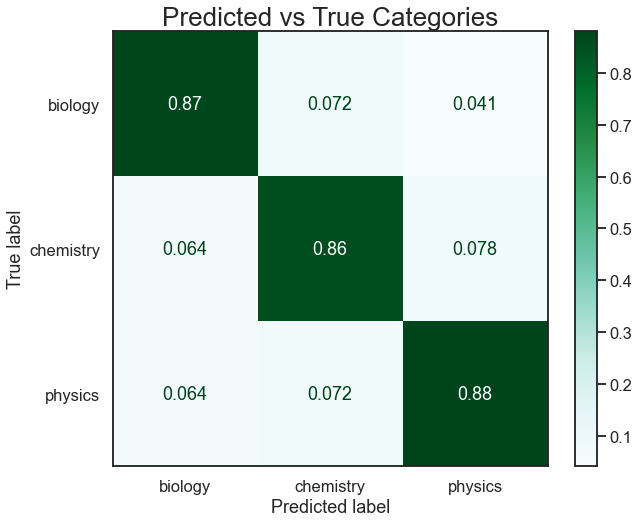

In [45]:
plot_cm(gs_svc, text_X_test, y_test, norm = 'pred')

In [46]:
#using accuracy score to find how often two predictors agree
metrics.accuracy_score(gs.predict(text_X_test), gs_svc.predict(text_X_test))

0.9717778177242495

In [47]:
# They agree on 97% of test data.

# Naive Bayes

In [49]:
#Grid-searched best paramters for multinomialNB

nb = Pipeline(steps=[('tv', TfidfVectorizer(max_df=10000)),
                ('nb', MultinomialNB(alpha=0.5))])

In [50]:
# nb = GridSearchCV(nb_pipe, param_grid=params, cv = 5, n_jobs=5)
nb.fit(text_X_train, y_train)
nb.score(text_X_train, y_train)

0.9358743857125734

In [51]:
nb.score(text_X_test, y_test)

0.8648211396728384

In [52]:
#Comparing prediction of NB to LR
metrics.accuracy_score(nb.predict(text_X_test), gs.predict(text_X_test))

0.9029300737012403

In [125]:
#These models agree on 90.3% of predictions

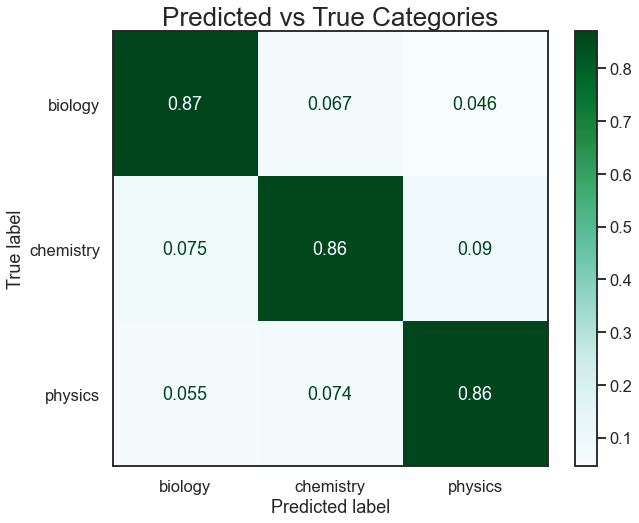

In [53]:
plot_cm(nb, text_X_test, y_test, norm = 'pred')

# AdaBoost

In [54]:


#Due to the time a single fit takes, AdaBoost Classifier was searched one parameter at a time, rather than using a Gridsearch

In [55]:
abc = AdaBoostClassifier(n_estimators=1000, learning_rate=0.2)

abc.fit(X_train_tv2g, y_train)
abc.score(X_train_tv2g, y_train)

0.8704902313316553

In [56]:
abc.score(X_test_tv2g, y_test)

0.8087362933668883

In [59]:
metrics.accuracy_score(nb.predict(text_X_test), abc.predict(X_test_tv2g))

#Comparing the predictions of NB and AdaBoost

0.8189825633650908

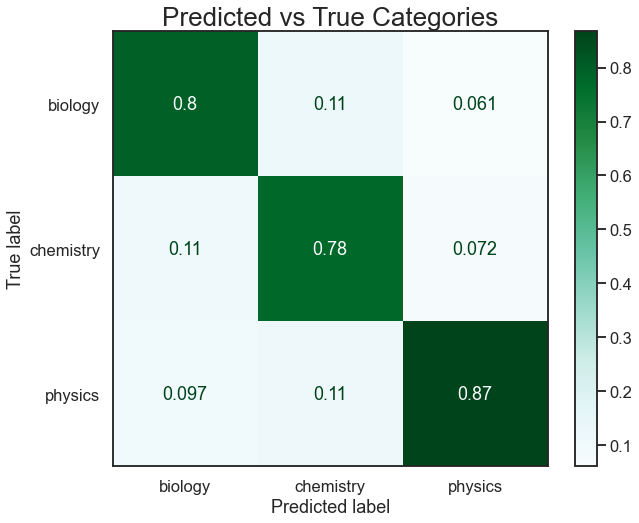

In [58]:
plot_cm(abc, X_test_tv2g, y_test, norm = 'pred')

# Voting algorithm

Although sklearn's voting model would work, not every model is fit the same way, so rather than re-working every model, I chose to write the code to calculate the vote myself. 'Hard' voting isn't complicated, and a 'soft' vote won't work with these models, as they don't all have a predict_proba method.

In [73]:
lr_preds = gs.predict(text_X_test)
nb_preds = nb.predict(text_X_test)
svc_preds = gs_svc.predict(text_X_test)
ada_preds = abc.predict(X_test_tv2g)
dt_preds = dt.predict(X_test_tv3g)
bc_preds = bc.predict(X_test_tv)

In [75]:
preds_df = pd.DataFrame({'lr' : lr_preds, 'nb' : nb_preds, 'svc' : svc_preds,
                         'ada' : ada_preds, 'dt' : dt_preds,
                        'bc' : bc_preds})

In [76]:
preds_df['vote'] = (preds_df[['svc', 'nb', 'ada']].mode(axis = 1)[0]).astype(int)

In [77]:
#LR and SVC agree over 97% of the time. Using them both is almost like having the same model vote twice. Best results come from SVC, NB, and ADA

In [78]:
metrics.accuracy_score(preds_df['vote'], y_test)

0.872550781952184

In [79]:
#At this point, if there is a tie in the vote, it defaults to 0 (Biology)
#Instead, we can use the best model as a tiebreaker to squeeze out a little bit more accuracy

In [80]:
preds_df = preds_df.drop(columns=['lr', 'dt', 'bc']) #drop the columns that weren't used

In [81]:
#Find the places where there was a 3-way tie and change those predictions to those of 'svc'
preds_df.loc[preds_df.T.nunique() > 2, 'vote'] = preds_df.loc[preds_df.T.nunique() > 2 , 'svc']

In [82]:
metrics.accuracy_score(preds_df['vote'], y_test)

0.8727305410749595

In [83]:
#This is a class to fool sklearn's plot_confusion_matrix
#This lets me instantiate the class to pass my predictions to the confusion matrix without giving it a real estimator

class FakeEstimator:
    #simply pass the predictions into the initializer
    def __init__(self, preds):
        self.preds = preds
        self._estimator_type = 'classifier' #this tricks plot_confusion_matrix
    
    #needs to 'predict'- it needs to be able to accept a paramater, but it doesn't use it
    def predict(self, X):
        return self.preds

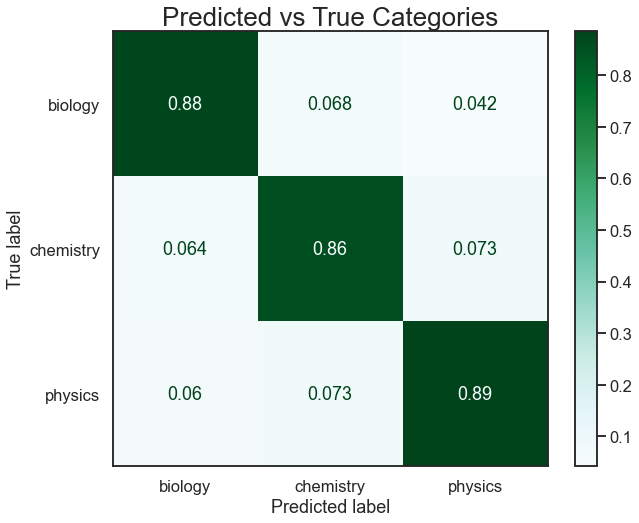

In [84]:
plot_cm(FakeEstimator(preds_df['vote']), X_test_tv, y_test, norm='pred')

In [85]:
#Finally, write the votes and predictions into a csv file for a little bit more analysis

In [86]:
df_to_write = fullX_test.copy()
df_to_write[['nb','svc','ada','vote']] = preds_df.values

In [87]:
df_to_write['y_true'] = y_test

In [236]:
df_to_write.to_csv('data/BCP_predictions.csv')